In [20]:
!pip install pandas
!pip install selenium
!pip install webdriver_manager
!pip install lxml
!pip install yfinance
!pip install tensorflow
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.15.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
Using cached scipy-1.15.1

In [21]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from time import sleep

import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [4]:
argo = 'https://www.set.or.th/th/market/index/set/agro'
consump = 'https://www.set.or.th/th/market/index/set/consump'
fincial = 'https://www.set.or.th/th/market/index/set/fincial'
indus = 'https://www.set.or.th/th/market/index/set/indus'
propcon = 'https://www.set.or.th/th/market/index/set/propcon'
resource = 'https://www.set.or.th/th/market/index/set/resourc'
service = 'https://www.set.or.th/th/market/index/set/service'
tech = 'https://www.set.or.th/th/market/index/set/tech'

In [5]:
# Scrap the most exchange value from SET
def scrape_industry_data(driver):
    
    industry_urls = {
        "agro": "https://www.set.or.th/th/market/index/set/agro",
        "consump": "https://www.set.or.th/th/market/index/set/consump",
        "fincial": "https://www.set.or.th/th/market/index/set/fincial",
        "indus": "https://www.set.or.th/th/market/index/set/indus",
        "propcon": "https://www.set.or.th/th/market/index/set/propcon",
        "resource": "https://www.set.or.th/th/market/index/set/resourc",
        "service": "https://www.set.or.th/th/market/index/set/service",
        "tech": "https://www.set.or.th/th/market/index/set/tech"
    }

    industry_data = {}

    for industry, url in industry_urls.items():
        print(f"Scraping {industry} data from {url}...")
        driver.get(url)
        sleep(5)  
        driver.execute_script("window.scrollTo(0, 1500)")  
        sleep(5)  
    
        retry_attempts = 3  
        data_cleaned = None  

        for attempt in range(retry_attempts):
            try:
                data_list = pd.read_html(driver.page_source)
                if len(data_list) > 1:
                    data_cleaned = data_list[1].dropna(how="all")  # Clean the data

            # If data_cleaned is not empty, break the retry loop
                if data_cleaned is not None and not data_cleaned.empty:
                    print(data_cleaned)
                    industry_data[industry] = data_cleaned  # Store in dictionary
                    print(f"Successfully scraped {industry} data.")
                    break
                else:
                    print(f"No data found for {industry}. Retrying... (Attempt {attempt + 1})")
                    sleep(5)  # Wait before retrying
                    driver.refresh()  # Refresh the page

            except Exception as e:
                print(f"Error scraping {industry} on attempt {attempt + 1}: {e}")
        else:
            print(f"Failed to scrape data for {industry} after {retry_attempts} attempts.")

    return industry_data

# Get the top 5
def get_top_5_by_value(dataframe):
    if dataframe.empty or "มูลค่า ('000 บาท)" not in dataframe.columns:
        return pd.DataFrame(columns=["หลักทรัพย์", "มูลค่า ('000 บาท)"])  # Return empty DataFrame if missing data

    dataframe["มูลค่า ('000 บาท)"] = pd.to_numeric(dataframe["มูลค่า ('000 บาท)"], errors="coerce")
    
    dataframe = dataframe.dropna(subset=["มูลค่า ('000 บาท)"])

    top_5 = dataframe.sort_values(by="มูลค่า ('000 บาท)", ascending=False).head(5)

    return top_5[["หลักทรัพย์", "มูลค่า ('000 บาท)"]]

# Extract for furthur input
def extract_top_5_data_with_tickers(source_data):
    top_5_industries = {industry: get_top_5_by_value(df) for industry, df in source_data.items()}
    
    # Extract only the top 5 names and add ".BK"
    top_5_names_industries = {
        industry: [f"{ticker}.BK" for ticker in df["หลักทรัพย์"].tolist()]
        for industry, df in top_5_industries.items()
    }

    return top_5_industries, top_5_names_industries

In [6]:
industry_data = scrape_industry_data(driver)

Scraping agro data from https://www.set.or.th/th/market/index/set/agro...


/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                         หลักทรัพย์   เปิด สูงสุด ต่ำสุด ล่าสุด เปลี่ยนแปลง  \
1    AGRO - เกษตรและอุตสาหกรรมอาหาร    NaN    NaN    NaN    NaN         NaN   
2             AGRI - ธุรกิจการเกษตร    NaN    NaN    NaN    NaN         NaN   
3                        EE  CB  CS   0.49   0.50   0.48   0.49       -0.01   
5                              GFPT   8.60   8.75   8.60   8.60        0.00   
7                               LEE   2.28   2.28   2.28   2.28        0.00   
..                              ...    ...    ...    ...    ...         ...   
134                              TU  11.50  11.60  11.40  11.40       -0.10   
136                             TVO  20.70  21.00  20.70  20.90       +0.20   
138                            TWPC   2.22   2.22   2.18   2.18       -0.04   
140                        XBIO  CB   0.29   0.30   0.29   0.29       -0.01   
142                             ZEN   6.60   7.00   6.60   7.00       +0.40   

    % เปลี่ยนแปลง  เสนอซื้อ  เสนอขาย ปริมาณ (หุ้น) 

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                             หลักทรัพย์    เปิด  สูงสุด  ต่ำสุด  ล่าสุด  \
1          CONSUMP - สินค้าอุปโภคบริโภค     NaN     NaN     NaN     NaN   
2                      FASHION - แฟชั่น     NaN     NaN     NaN     NaN   
3                                   AFC    3.70    3.80    3.58    3.80   
5                                  AURA   14.00   14.00   13.80   13.90   
7                                  BTNC       -       -       -       -   
9                                   CPH    7.80    7.90    7.80    7.90   
11                                  CPL    0.90    0.90    0.84    0.88   
13                                   NC    2.52    2.52    2.38    2.38   
15                                  PAF    0.90    0.90    0.84    0.84   
17                                  PDJ    1.84    1.84    1.64    1.73   
19                                   PG       -       -       -       -   
21                               SABINA   18.20   18.40   18.10   18.20   
23                       

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                  หลักทรัพย์    เปิด  สูงสุด  ต่ำสุด  ล่าสุด เปลี่ยนแปลง  \
1    FINCIAL - ธุรกิจการเงิน     NaN     NaN     NaN     NaN         NaN   
2              BANK - ธนาคาร     NaN     NaN     NaN     NaN         NaN   
3                        BAY   23.30   23.30   23.10   23.10       -0.20   
5                        BBL  152.50  153.50  152.00  152.50        0.00   
7                  CIMBT  CF    0.54    0.55    0.53    0.54        0.00   
..                       ...     ...     ...     ...     ...         ...   
137                     TIPH   21.60   21.60   21.20   21.30        0.00   
139                      TLI   11.00   11.20   10.90   11.00       +0.10   
141                      TQM   16.70   17.00   16.70   16.80        0.00   
143                  TSI  CB       -       -       -       -           -   
145                      TVH       -       -       -       -           -   

    % เปลี่ยนแปลง เสนอซื้อ เสนอขาย ปริมาณ (หุ้น) มูลค่า ('000 บาท)  
1             NaN 

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                   หลักทรัพย์   เปิด สูงสุด ต่ำสุด ล่าสุด เปลี่ยนแปลง  \
1    INDUS - สินค้าอุตสาหกรรม    NaN    NaN    NaN    NaN         NaN   
2              AUTO - ยานยนต์    NaN    NaN    NaN    NaN         NaN   
3                         ACG   0.78   0.78   0.78   0.78        0.00   
5                          AH  14.20  14.20  14.10  14.10        0.00   
7                         CWT   0.64   0.69   0.64   0.69       +0.04   
..                        ...    ...    ...    ...    ...         ...   
198                       THE   0.71   0.73   0.70   0.73        0.00   
200                       TMT   3.04   3.04   3.02   3.04       -0.02   
202                      TSTH   0.52   0.54   0.52   0.54       +0.02   
204                       TWP   1.20   1.20   1.10   1.13       -0.03   
206                      TYCN      -      -      -      -           -   

    % เปลี่ยนแปลง เสนอซื้อ เสนอขาย ปริมาณ (หุ้น) มูลค่า ('000 บาท)  
1             NaN      NaN     NaN           NaN      

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                               หลักทรัพย์  เปิด สูงสุด ต่ำสุด ล่าสุด  \
1    PROPCON - อสังหาริมทรัพย์และก่อสร้าง   NaN    NaN    NaN    NaN   
2                  CONMAT - วัสดุก่อสร้าง   NaN    NaN    NaN    NaN   
3                                     CCP  0.21   0.22   0.20   0.21   
5                                     DCC  1.61   1.62   1.58   1.58   
7                                    DCON  0.30   0.30   0.29   0.30   
..                                    ...   ...    ...    ...    ...   
334                               TRC  CB  0.94   0.94   0.91   0.94   
336                                 TRITN  0.10   0.11   0.10   0.10   
338                                  TTCL  1.65   1.67   1.59   1.62   
340                                  UNIQ  2.02   2.04   2.00   2.00   
342                                   WGE  0.74   0.75   0.74   0.74   

    เปลี่ยนแปลง % เปลี่ยนแปลง เสนอซื้อ  เสนอขาย ปริมาณ (หุ้น)  \
1           NaN           NaN      NaN      NaN           NaN   
2    

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


                        หลักทรัพย์  เปิด  สูงสุด  ต่ำสุด  ล่าสุด  เปลี่ยนแปลง  \
1               RESOURC - ทรัพยากร   NaN     NaN     NaN     NaN          NaN   
2    ENERG - พลังงานและสาธารณูปโภค   NaN     NaN     NaN     NaN          NaN   
3                              ACC  0.40    0.41    0.39    0.40         0.00   
5                              ACE  1.31    1.31    1.27    1.28        -0.03   
7                               AE  0.16    0.17    0.16    0.16         0.00   
..                             ...   ...     ...     ...     ...          ...   
119                            TTW  8.80    8.90    8.80    8.85         0.05   
121                            UBE  0.51    0.52    0.50    0.52         0.01   
123                          WHAUP  3.46    3.60    3.46    3.58         0.14   
125                             WP  3.24    3.24    3.04    3.20        -0.08   
127               MINE - เหมืองแร่   NaN     NaN     NaN     NaN          NaN   

     % เปลี่ยนแปลง  เสนอซื้

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


           หลักทรัพย์  เปิด สูงสุด ต่ำสุด ล่าสุด เปลี่ยนแปลง % เปลี่ยนแปลง  \
1    SERVICE - บริการ   NaN    NaN    NaN    NaN         NaN           NaN   
2      COMM - พาณิชย์   NaN    NaN    NaN    NaN         NaN           NaN   
3              ADVICE  4.66   4.84   4.66   4.82       +0.12         +2.55   
5             B52  CB  0.28   0.30   0.27   0.28        0.00          0.00   
7              BEAUTY  0.22   0.23   0.21   0.22        0.00          0.00   
..                ...   ...    ...    ...    ...         ...           ...   
268             TFFIF  6.30   6.40   6.30   6.30        0.00          0.00   
270  THAI  SP  NC  NP     -      -      -      -           -             -   
272              TSTE     -      -      -      -           -             -   
274               TTA  4.04   4.26   4.04   4.20       +0.16         +3.96   
276              WICE  3.30   3.30   3.26   3.26       -0.04         -1.21   

    เสนอซื้อ เสนอขาย ปริมาณ (หุ้น) มูลค่า ('000 บาท)  
1       

/var/folders/vw/288jn05573d78l0mr6f151zc0000gn/T/ipykernel_97248/2857208460.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data_list = pd.read_html(driver.page_source)


In [8]:
top_5_industries = {
    industry: get_top_5_by_value(df) for industry, df in industry_data.items()
}

print("\n========= TOP 5 for Pulling from Yahoo Finance =========")
print(top_5_names_industries)

# Print results
print("\n========= TOP 5 with Values =========")
for industry, top_5 in top_5_industries.items():
    print(f"\nTop 5 for {industry}:")
    print(top_5)

top_5_industries, top_5_names_industries = extract_top_5_data_with_tickers(industry_data)

# Print the top 5 names with '.BK' appended
print("\n========= TOP 5 with .BK =========")
for industry, names in top_5_names_industries.items():
    print(f"\nTop 5 tickers for {industry}:")
    print(names)


========= TOP 5 for Pulling from Yahoo Finance =========
{'agro': ['CBG.BK', 'OKJ.BK', 'OSP.BK', 'M.BK', 'TU.BK'], 'consump': ['AURA.BK', 'STGT.BK', 'SABINA.BK', 'NEO.BK', 'SNPS.BK'], 'fincial': ['KBANK.BK', 'KTB.BK', 'BBL.BK', 'SCB.BK', 'TTB.BK'], 'indus': ['IVL.BK', 'SCGP.BK', 'PTTGC.BK', 'TPCS.BK', 'RSXYZ.BK'], 'propcon': ['AMATA.BK', 'WHA.BK', 'CPN.BK', 'SCC.BK', 'LH.BK'], 'resource': ['GULF.BK', 'TOP.BK', 'PTTEP.BK', 'BCP.BK', 'GPSC.BK'], 'service': ['CPALL.BK', 'AOT.BK', 'BH.BK', 'BDMS.BK', 'BTS.BK'], 'tech': ['ADVANC.BK', 'INTUCH.BK', 'CCET.BK', 'DELTA.BK', 'TRUE.BK']}

========= TOP 5 with Values =========

Top 5 for agro:
    หลักทรัพย์  มูลค่า ('000 บาท)
42         CBG          152273.64
92         OKJ          114657.95
94         OSP          102153.51
84           M           60630.15
134         TU           48197.01

Top 5 for consump:
   หลักทรัพย์  มูลค่า ('000 บาท)
5        AURA           14612.58
91       STGT           11308.94
21     SABINA           10808.27
81  

In [9]:
import yfinance as yf

# Download historical data for all stocks
start_date = "2024-12-11"
end_date = "2025-02-10"

def get_40_stocks_data(top_5_names_industries):
    all_data = {}
    for industry, tickers in top_5_names_industries.items():
        print(f"Downloading data for {industry} stocks...")
        for ticker in tickers:
            data = yf.download(ticker, start=start_date, end=end_date)
            all_data[ticker] = data  # Store data by ticker
            print(f"Downloaded data for {ticker}")
    return all_data

all_data = get_40_stocks_data(top_5_names_industries)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for CBG.BK
Downloaded data for OKJ.BK
Downloaded data for OSP.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for M.BK
Downloaded data for TU.BK
Downloaded data for AURA.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for STGT.BK
Downloaded data for SABINA.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for NEO.BK
Downloaded data for SNPS.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for KBANK.BK
Downloaded data for KTB.BK
Downloaded data for BBL.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for SCB.BK
Downloaded data for TTB.BK
Downloaded data for IVL.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for SCGP.BK
Downloaded data for PTTGC.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for TPCS.BK
Downloaded data for RSXYZ.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for AMATA.BK
Downloaded data for WHA.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for CPN.BK
Downloaded data for SCC.BK



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for LH.BK
Downloaded data for GULF.BK
Downloaded data for TOP.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for PTTEP.BK
Downloaded data for BCP.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for GPSC.BK
Downloaded data for CPALL.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for AOT.BK
Downloaded data for BH.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for BDMS.BK
Downloaded data for BTS.BK



[*********************100%***********************]  1 of 1 completed


Downloaded data for ADVANC.BK
Downloaded data for INTUCH.BK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for CCET.BK
Downloaded data for DELTA.BK
Downloaded data for TRUE.BK


In [22]:
# Get close price function from each of the stock
def get_close_price(stock):
    return all_data[stock][['Close']]

data_true = get_close_price("TRUE.BK")

In [23]:
data_true['Close']

Ticker,TRUE.BK
Date,
2024-12-11,11.9
2024-12-12,11.9
2024-12-13,11.8
2024-12-16,11.9
2024-12-17,11.5
2024-12-18,11.0
2024-12-19,10.6
2024-12-20,10.6
2024-12-23,11.2


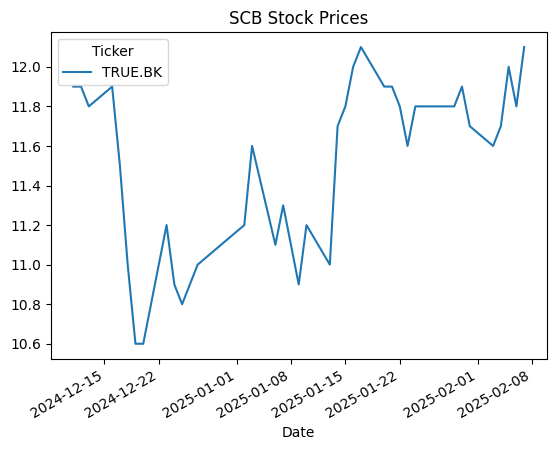

In [24]:
data_scb['Close'].plot()
plt.title("SCB Stock Prices")
plt.show()